texting elements of network visualization

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from networkx.algorithms.community.centrality import girvan_newman
from collections import Counter
from itertools import combinations
import itertools
import json


In [2]:
data_file = '../scraped_data/tags_1e5_posts.json'
df = pd.read_json(data_file)

In [3]:
 def append_neighbors_to_df(full_df, top_tags_df):
    
    #dictionary of all related tags
    related_tags = {}
    for dic in top_tags_df['relatedTags']:
        related_tags.update(dic)

    for key in related_tags.keys():
        if key not in top_tags_df['name'].values:
            df_entry = full_df[full_df['name'] == key]
            top_tags_df = top_tags_df.append(df_entry)
            
    return top_tags_df

def add_to_graph(graph, top_tags_df ):
    
    for _, tag in top_tags_df.iterrows():

        graph.add_node(tag['name'], size = tag['postCount']/10)


        combination_of_nodes = [(tag['name'],related_tag) for related_tag in tag['relatedTags']]

        for edge in combination_of_nodes:

            if edge in graph.edges:
                pass
            else:
                if edge[1] not in graph.nodes.data() and edge[1] not in top_tags_df['name'].values :
                    graph.add_node(edge[1], size=tag['relatedTags'][edge[1]]/10)
                graph.add_edge(*edge)
    return graph
                
    
def visualize_network(dataframe, starting_tags, second_degree=False, third_degree = False, title=None):
    
    top_tags_df = dataframe[dataframe['name'].isin(starting_tags)]
    
    G = nx.Graph()
    sizes = []
    
    if second_degree:
        top_tags_df = append_neighbors_to_df(dataframe, top_tags_df)
        if third_degree:
            top_tags_df = append_neighbors_to_df(dataframe, top_tags_df)

                
    G = add_to_graph(G, top_tags_df)
                
    plt.figure(figsize=[50,50])
    if title:
#         plt.title('Top {0} Tags and their direct neighbors'.format(top_n),fontsize=75)
        plt.title(title)
    
    nx.draw_kamada_kawai(G,
            with_labels=True,
            font_weight='bold',
            font_size=35,
            node_size=[node[1] for node in G.nodes.data('size')],
            weight='frequency')
    return G
def top_n_tags(dataframe, n):
    
    return dataframe.sort_values(by='postCount', ascending = False).head(n)['name'].values

def export_json_data(graph, outfile_name):
    data = {'nodes':[], 'links':[]}
    for node in G.nodes:
        data['nodes'].append({'id':node})
    for edge in G.edges:
        data['links'].append({'source':edge[0], 'target':edge[1]})
    
    with open('../../visualization/'+outfile_name, 'w') as outfile:
        json.dump(data, outfile)

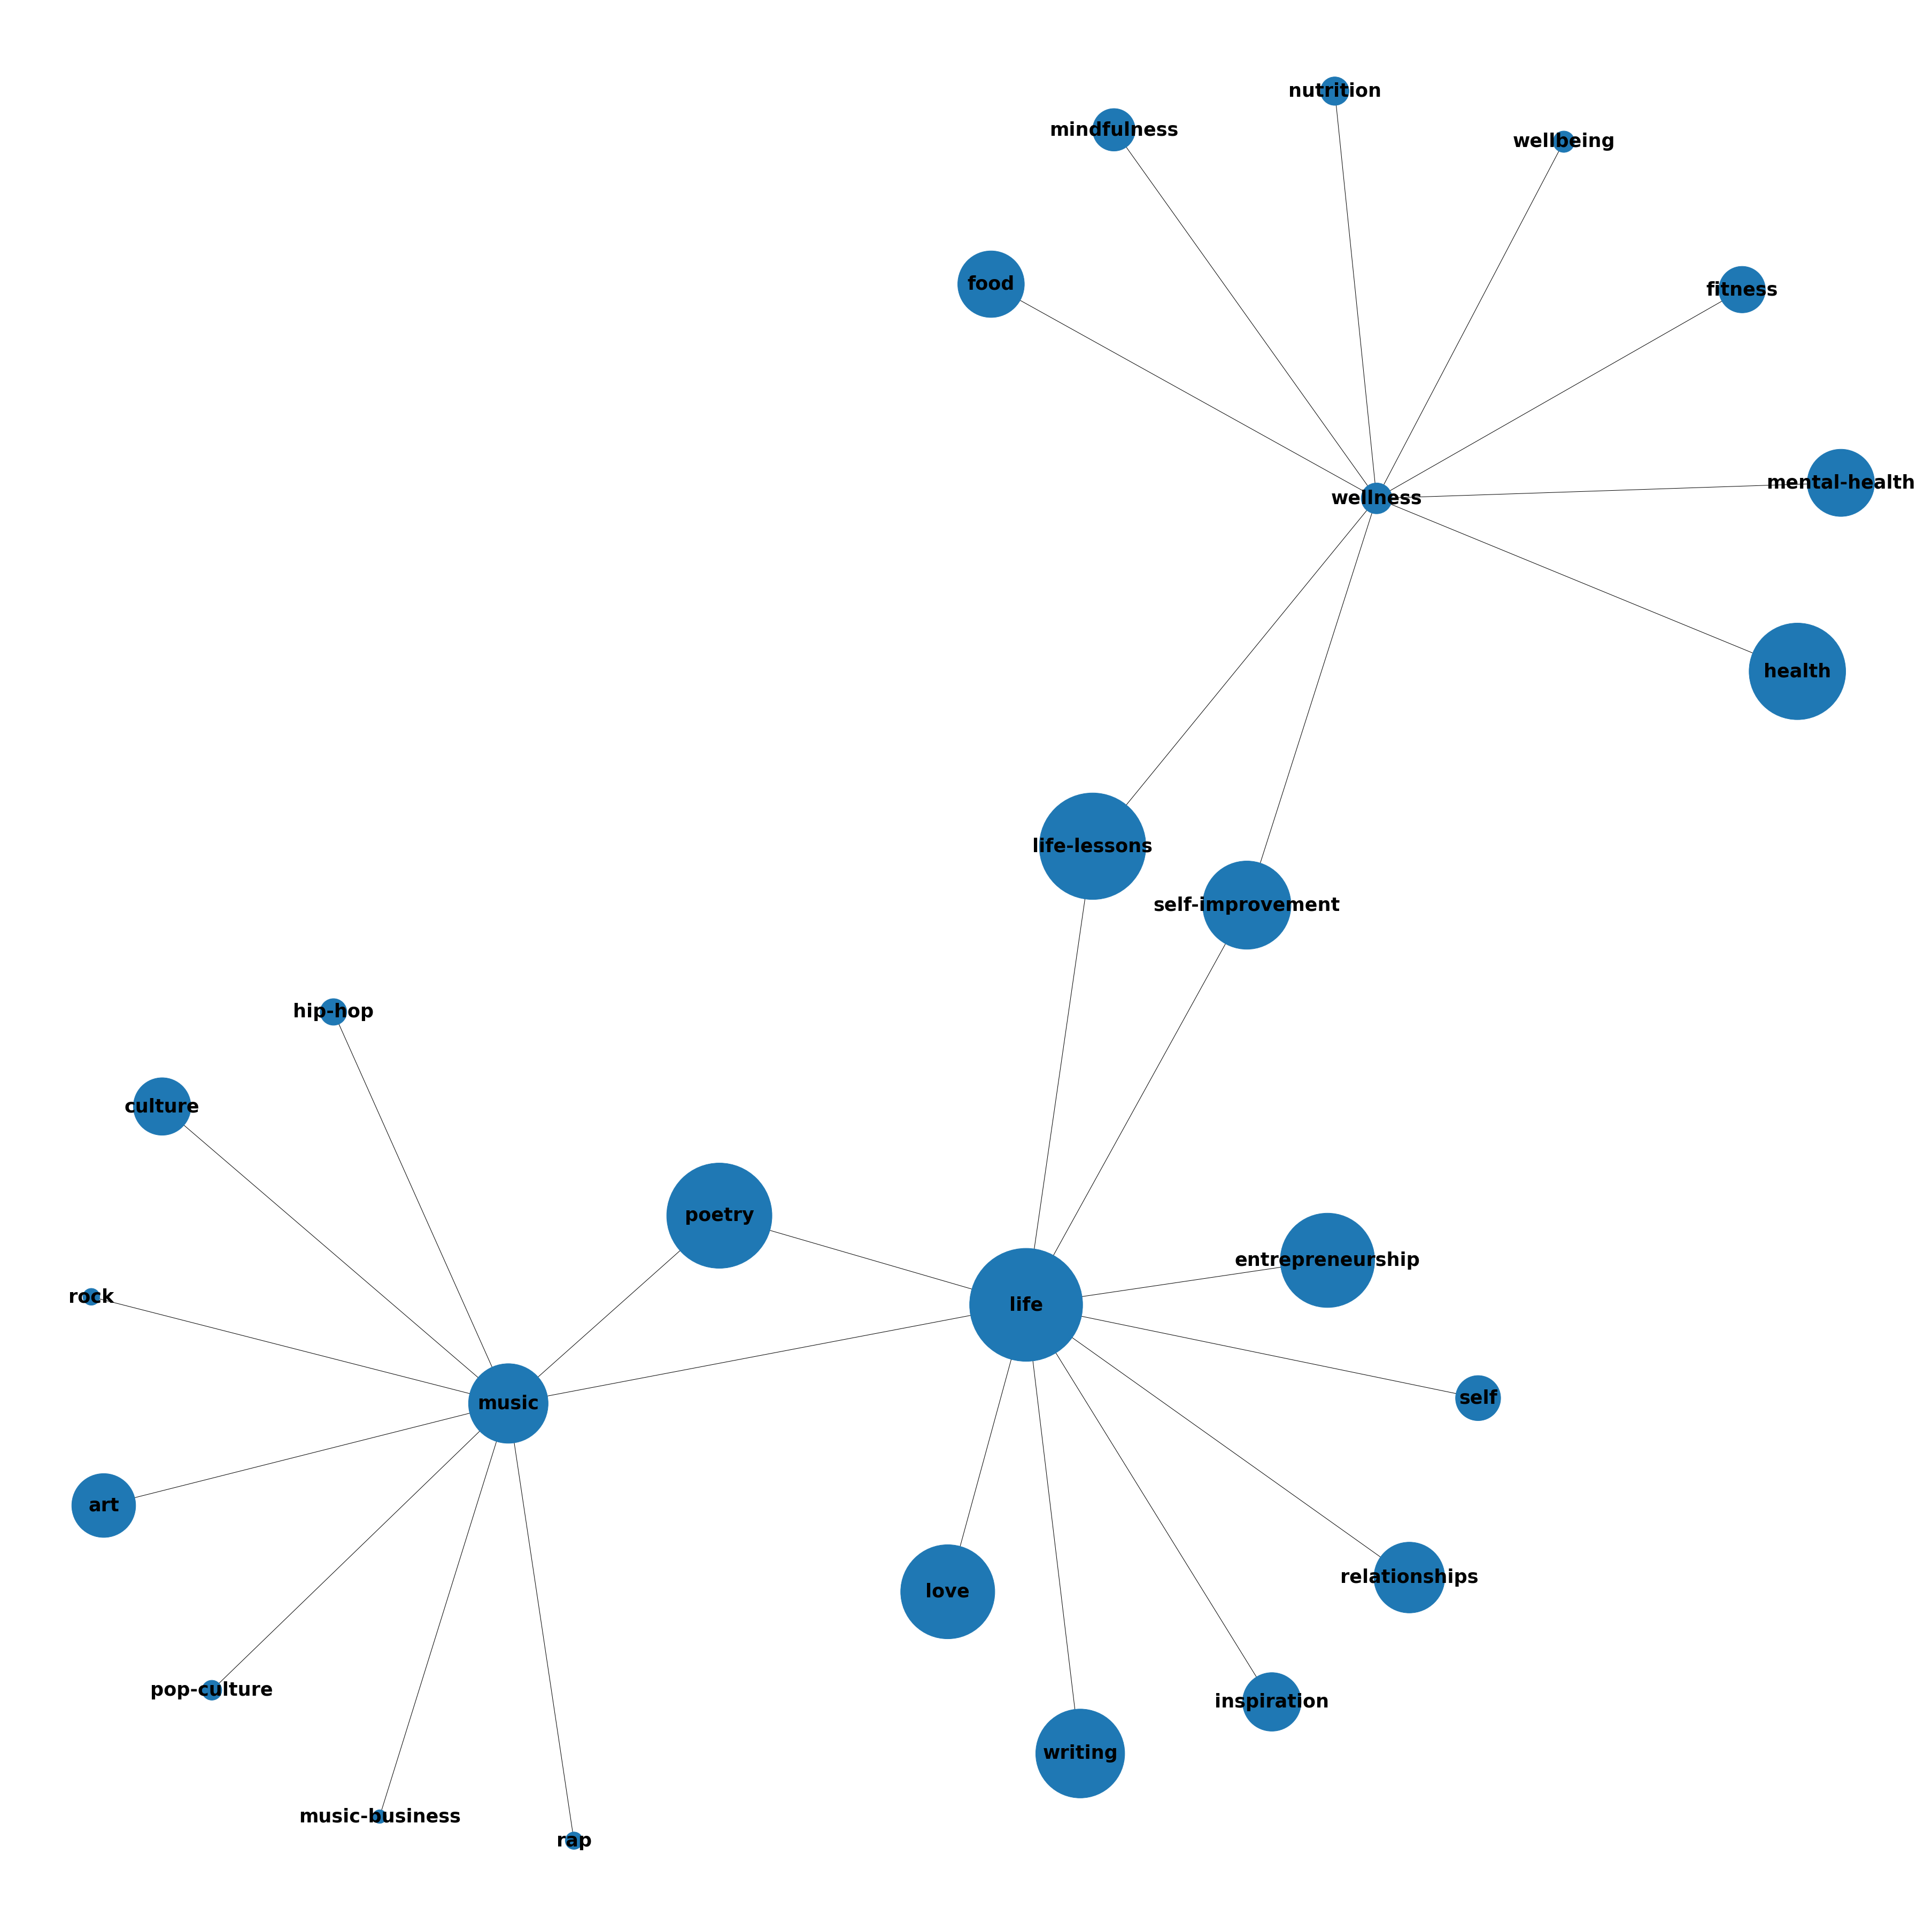

In [78]:
G = visualize_network(df, ['music', 'wellness', 'life'])

# find communities in network using Girvan–Newman algorithm 

The Girvan–Newman algorithm detects communities by progressively removing edges from the original graph. The algorithm removes the “most valuable” edge, traditionally the edge with the highest betweenness centrality, at each step. As the graph breaks down into pieces, the tightly knit community structure is exposed and the result can be depicted as a dendrogram.

In [79]:
def get_community_size_k(iterable_of_lists_of_communities, k):
    for list_of_communities in iterable_of_lists_of_communities:
        if len(list_of_communities)>k:
            next(list_of_communities)
            continue
        elif len(list_of_communities) == k:
            return [list(community) for community in list_of_communities]
            break

In [80]:
communities = get_community_size_k(girvan_newman(G), 3)

In [84]:
community_labels = {}
for i, community in enumerate(communities):
    for node in community:
        community_labels[node] = i
nx.set_node_attributes(G, community_labels, 'community')

In [95]:
communities

[['wellbeing',
  'fitness',
  'health',
  'nutrition',
  'mental-health',
  'wellness',
  'food',
  'mindfulness'],
 ['relationships',
  'inspiration',
  'life',
  'life-lessons',
  'writing',
  'entrepreneurship',
  'self',
  'self-improvement',
  'love'],
 ['music',
  'hip-hop',
  'culture',
  'art',
  'rock',
  'music-business',
  'rap',
  'pop-culture',
  'poetry']]

In [94]:
for node, comm in zip(G.nodes, G.nodes.values()):
    print(node,comm['community'])

wellness 0
health 0
mental-health 0
fitness 0
self-improvement 1
wellbeing 0
nutrition 0
mindfulness 0
life-lessons 1
food 0
music 2
hip-hop 2
culture 2
rock 2
art 2
poetry 2
life 1
pop-culture 2
music-business 2
rap 2
love 1
writing 1
inspiration 1
relationships 1
self 1
entrepreneurship 1


# Next step: use community label to color 

check out different community definitions